<a href="https://colab.research.google.com/github/lailatulbadriyah24/2141720036-machine-learning-2023/blob/main/praktikum-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Praktikum 1: RNN untuk Analisis Sentimen**

### **Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup Input Pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [3]:
# Mengunduh dataset 'imdb_reviews' dari TensorFlow Datasets (tfds)
# 'with_info=True' digunakan untuk memuat informasi tambahan tentang dataset
# 'as_supervised=True' digunakan untuk memuat dataset dalam bentuk pasangan (data, label)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi dataset pelatihan dan dataset pengujian
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan struktur elemen dari dataset pelatihan
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
# Mengambil satu contoh dari dataset pelatihan menggunakan 'train_dataset.take(1)'
# Ini akan menghasilkan satu pasangan (data, label)
for example, label in train_dataset.take(1):
  # Mencetak teks ulasan dari contoh sebagai nilai dalam bentuk numpy array
  print('text: ', example.numpy())
  # Mencetak label dari contoh sebagai nilai dalam bentuk numpy array
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
# Menentukan ukuran buffer untuk shuffle
BUFFER_SIZE = 10000

# Menentukan ukuran batch
BATCH_SIZE = 64

# Mengacak ulang (shuffle) dataset pelatihan dengan buffer sebesar BUFFER_SIZE
# dan membaginya menjadi batch dengan ukuran BATCH_SIZE
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Memisahkan dataset pengujian menjadi batch dengan ukuran BATCH_SIZE
# dan menggunakan prefetching untuk mempercepat pembacaan data
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Mengambil satu batch (dalam hal ini, pertama) dari dataset pelatihan
for example, label in train_dataset.take(1):
  # Mencetak tiga teks ulasan pertama dalam batch
  print('texts: ', example.numpy()[:3])
  print()
  # Mencetak tiga label pertama dalam batch
  print('labels: ', label.numpy()[:3])

texts:  [b"I first saw this movie when I was about 10 years old. My mom bought it at our local Kmart because it was on sale for $5 on VHS. She thought that it would be a nice Christmas movie for me and my brothers to watch. This movie, however, scared the hell out of me. You may be asking yourself, how could a movie about Santa Clause scare anyone? The plot of the movie revolves around Satan sending one his minions, Pitch, to earth in an attempt to kill Santa and ruin Christmas. That's right, Satan sends a demon up from hell to kill Santa Clause. Pitch stalks Santa throughout Christmas eve in an attempt to trap him on earth when the sun rises on Christmas day, for if Santa doesn't make it back to his home in space, he turns to powder. Don't get me wrong, the movie is funny and fairly entertaining, however, the image of demons and devils dancing in the depths of hell (which occurs at the beginning of the movie) is just downright creepy."
 b'For those who like depressing films with sleaz

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
# Menentukan ukuran vokabuler (VOCAB_SIZE)
VOCAB_SIZE = 1000

# Membuat sebuah objek TextVectorization (encoder) dengan batasan jumlah token maksimal (max_tokens) sebesar VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Menyesuaikan encoder dengan dataset pelatihan
# Menggunakan metode 'adapt' untuk mengambil teks dari dataset pelatihan
# 'train_dataset.map(lambda text, label: text)' digunakan untuk mengambil hanya teks (tanpa label) dari setiap contoh dataset pelatihan
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
# Mengambil vokabuler dari encoder
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 token pertama dalam vokabuler
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
# Menggunakan encoder untuk mengonversi tiga contoh teks pertama dalam dataset pelatihan
encoded_example = encoder(example)[:3].numpy()

# Mencetak hasil representasi numerik dari teks
encoded_example

array([[ 10,  86, 208, ...,   0,   0,   0],
       [ 16, 144,  37, ...,   0,   0,   0],
       [ 10, 326,   2, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
- Nilai default untuk argumen standarisasi preprocessing TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
# Loop untuk melakukan round-trip pada tiga contoh
for n in range(3):
  # Mencetak teks asli
  print("Original: ", example[n].numpy())

  # Menggunakan vokabuler (vocab) untuk mengubah representasi numerik (encoded_example) kembali menjadi teks
  # " ".join()" digunakan untuk menggabungkan token-token dalam satu kalimat
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))

  # Mencetak baris kosong untuk pemisah
  print()

Original:  b"I first saw this movie when I was about 10 years old. My mom bought it at our local Kmart because it was on sale for $5 on VHS. She thought that it would be a nice Christmas movie for me and my brothers to watch. This movie, however, scared the hell out of me. You may be asking yourself, how could a movie about Santa Clause scare anyone? The plot of the movie revolves around Satan sending one his minions, Pitch, to earth in an attempt to kill Santa and ruin Christmas. That's right, Satan sends a demon up from hell to kill Santa Clause. Pitch stalks Santa throughout Christmas eve in an attempt to trap him on earth when the sun rises on Christmas day, for if Santa doesn't make it back to his home in space, he turns to powder. Don't get me wrong, the movie is funny and fairly entertaining, however, the image of demons and devils dancing in the depths of hell (which occurs at the beginning of the movie) is just downright creepy."
Round-trip:  i first saw this movie when i was 

### **Buat Model**

In [10]:
# Membuat sebuah model sequential
model = tf.keras.Sequential([
    # Encoder (TextVectorization) untuk mengonversi teks ke representasi numerik
    encoder,

    # Layer embedding dengan input_dim sesuai dengan ukuran vokabuler
    # dan output_dim sebesar 64
    # 'mask_zero=True' digunakan untuk mengatasi panjang urutan teks yang bervariasi
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),

    # Layer Bidirectional LSTM dengan 64 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dense dengan 1 unit (kemungkinan output biner)
    tf.keras.layers.Dense(1)
])

In [11]:
# Menggunakan list comprehension untuk membuat daftar yang berisi informasi apakah setiap lapisan mendukung masking
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# Teks sampel yang akan diprediksi
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi pada teks sampel
# Menggunakan model.predict() dengan teks sampel yang diubah menjadi NumPy array
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.00032142]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[-0.00032142]


Compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
# Mengompilasi model dengan konfigurasi tertentu
model.compile(
    # Fungsi kerugian (loss function)
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    # Optimizer (algoritma pelatihan), dalam hal ini, menggunakan Adam dengan laju pembelajaran 1e-4
    optimizer=tf.keras.optimizers.Adam(1e-4),

    # Metrik evaluasi yang akan digunakan selama pelatihan, dalam hal ini, akurasi (accuracy)
    metrics=['accuracy']
)

### **Train Model**

In [15]:
# Melatih model dengan data pelatihan selama 10 epoek
# Menggunakan model.fit() untuk melatih model
# 'train_dataset' adalah dataset pelatihan
# 'validation_data' adalah dataset validasi
# 'validation_steps' adalah jumlah langkah validasi yang akan dieksekusi
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoek
    validation_data=test_dataset,  # Dataset validasi
    validation_steps=30  # Jumlah langkah validasi
)

Epoch 1/10
391/391 [==============================] - 52s 106ms/step - loss: 0.6322 - accuracy: 0.5827 - val_loss: 0.4697 - val_accuracy: 0.7943
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3941 - accuracy: 0.8198 - val_loss: 0.3589 - val_accuracy: 0.8318
Epoch 3/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3340 - accuracy: 0.8529 - val_loss: 0.3474 - val_accuracy: 0.8339
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3238 - accuracy: 0.8596 - val_loss: 0.3380 - val_accuracy: 0.8401
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3138 - accuracy: 0.8650 - val_loss: 0.3368 - val_accuracy: 0.8411
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3073 - accuracy: 0.8673 - val_loss: 0.3232 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3054 - accuracy: 0.8687 - val_loss: 0.3241 - val_accuracy

In [16]:
# Menggunakan model.evaluate() untuk mengevaluasi model menggunakan dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil loss dan akurasi pengujian
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 15s 37ms/step - loss: 0.3227 - accuracy: 0.8616
Test Loss: 0.3227335810661316
Test Accuracy: 0.8615999817848206


(0.0, 0.6489471137523651)

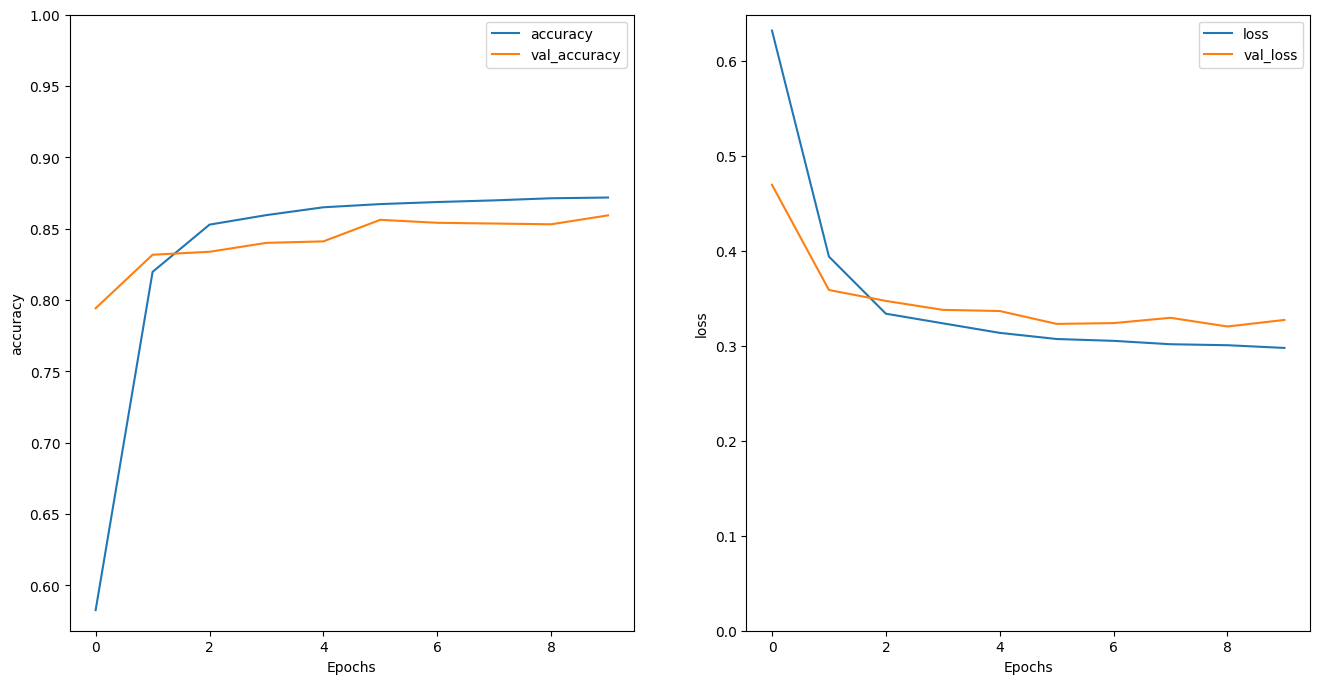

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 33ms/step
[0.76273924]


### **Stack two or more LSTM layers**

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [21]:
# Membuat model dengan arsitektur yang berbeda
model = tf.keras.Sequential([
    # Encoder (TextVectorization) untuk mengonversi teks ke representasi numerik
    encoder,

    # Layer embedding dengan input_dim sesuai dengan ukuran vokabuler
    # dan output_dim sebesar 64, dengan masking
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    # Layer Bidirectional LSTM dengan 64 unit dan return_sequences=True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Layer Bidirectional LSTM kedua dengan 32 unit
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Layer Dense dengan 64 unit dan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Layer Dropout dengan tingkat dropout 0.5
    tf.keras.layers.Dropout(0.5),

    # Layer Dense Akhir dengan 1 unit
    tf.keras.layers.Dense(1)
])

In [22]:
# Mengompilasi model dengan konfigurasi tertentu
model.compile(
    # Fungsi kerugian (loss function)
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    # Optimizer (algoritma pelatihan), dalam hal ini, menggunakan Adam dengan laju pembelajaran 1e-4
    optimizer=tf.keras.optimizers.Adam(1e-4),

    # Metrik evaluasi yang akan digunakan selama pelatihan, dalam hal ini, akurasi (accuracy)
    metrics=['accuracy']
)

In [23]:
# Melatih model dengan data pelatihan selama 10 epoek
# Menggunakan model.fit() untuk melatih model
# 'train_dataset' adalah dataset pelatihan
# 'validation_data' adalah dataset validasi
# 'validation_steps' adalah jumlah langkah validasi yang akan dieksekusi
history = model.fit(
    train_dataset,  # Dataset pelatihan
    epochs=10,  # Jumlah epoek
    validation_data=test_dataset,  # Dataset validasi
    validation_steps=30  # Jumlah langkah validasi
)

Epoch 1/10
391/391 [==============================] - 79s 157ms/step - loss: 0.6384 - accuracy: 0.5642 - val_loss: 0.4506 - val_accuracy: 0.7854
Epoch 2/10
391/391 [==============================] - 49s 126ms/step - loss: 0.3933 - accuracy: 0.8226 - val_loss: 0.3563 - val_accuracy: 0.8406
Epoch 3/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3377 - accuracy: 0.8547 - val_loss: 0.3587 - val_accuracy: 0.8323
Epoch 4/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3257 - accuracy: 0.8609 - val_loss: 0.3342 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3127 - accuracy: 0.8648 - val_loss: 0.3302 - val_accuracy: 0.8474
Epoch 6/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3122 - accuracy: 0.8650 - val_loss: 0.3312 - val_accuracy: 0.8396
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3054 - accuracy: 0.8712 - val_loss: 0.3247 - val_ac

In [24]:
# Menggunakan model.evaluate() untuk mengevaluasi model menggunakan dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil loss dan akurasi pengujian
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3293 - accuracy: 0.8644
Test Loss: 0.3292587995529175
Test Accuracy: 0.8644400238990784


In [25]:
# Teks sampel yang akan diprediksi
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Melakukan prediksi pada teks sampel
# Anda menggunakan model.predict() dengan teks sampel yang diubah menjadi NumPy array
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-1.6952888]]


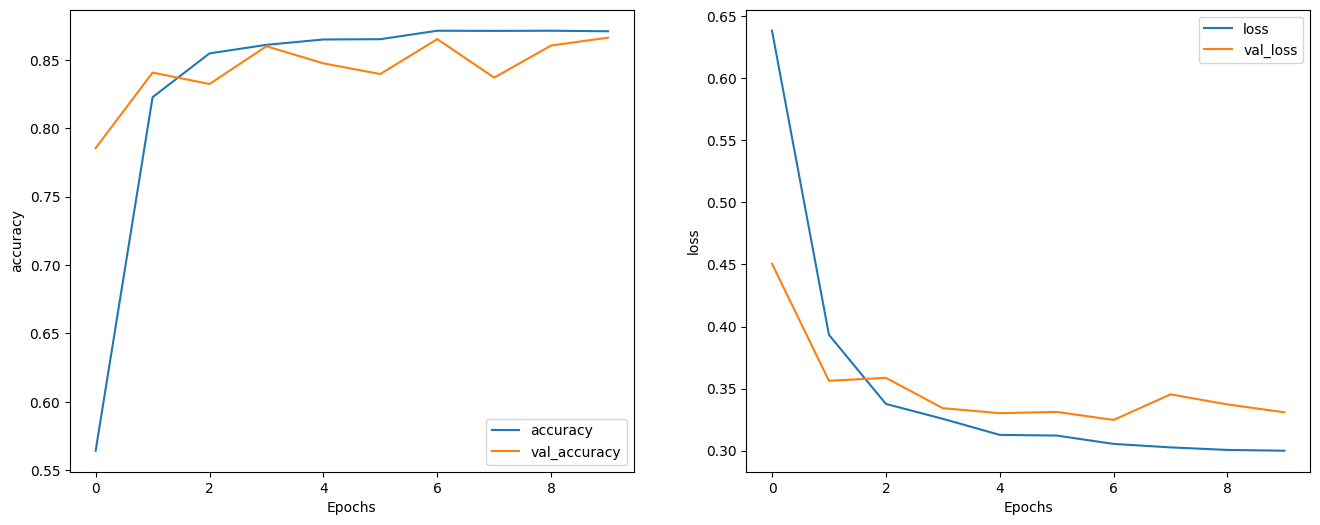

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')